# Import des bibliothèque et des données

In [20]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns

Disp_volaille = pd.read_csv('./Disp_volaille.csv')
colonnes = ["Disponibilité alimentaire en quantité (kg/personne/an)", "Importations - Quantité", "Production","Variation de stock"]

# Outliers

In [21]:
# Suppression des outliers qui sont des pays à forte population.
# Le Japon n'a pas une grande population mais une variation de stock extrêmement élevé.

# Cela reste des pays intéressant mais qui perturbe un peu trop notre ACP et notre clustering à venir.

Outliers = Disp_volaille.loc[[52,21,169,34,66,75]]
Outliers['cluster'] = 6
display(Outliers)

Disp_volaille = Disp_volaille.drop([52,21,169,34,66,75])

,Zone,Disponibilité alimentaire en quantité (kg/personne/an),Importations - Quantité,Production,Variation de stock,cluster
52,Fédération de Russie,30.98,226.0,4444.0,-1.0,6
21,Brésil,48.03,3.0,14201.0,0.0,6
169,États-Unis d'Amérique,55.68,123.0,21914.0,80.0,6
34,"Chine, continentale",12.33,452.0,18236.0,-50.0,6
66,Inde,2.22,0.0,3545.0,-119.0,6
75,Japon,18.50,1069.0,2215.0,859.0,6


# Standardisation des données

In [22]:
scaler = RobustScaler()
Volaille_std = scaler.fit_transform(Disp_volaille[colonnes])

# ACP

In [23]:
ACP = PCA(n_components=len(colonnes))
PC = ACP.fit_transform(Volaille_std)
res = pd.DataFrame(data=PC, columns=['PC1','PC2','PC3','PC4'])

# Eboulie des valeurs propres

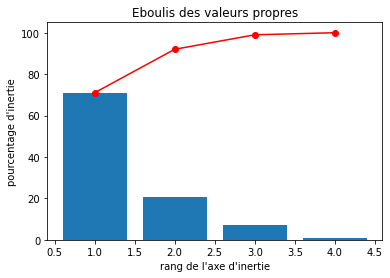

In [24]:
n_components = len(colonnes)

scree = (ACP.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.savefig("./images/Eboulis_des_valeurs_propres.svg", format="svg")
plt.show(block=False)

In [25]:
def cercle_correlation(pca, x_y, colonnes):

    """
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : liste des colonnes que l'on souhaite utiliser pour l'ACP
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en pouce)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les étiquettes
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                colonnes[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))

    # Axes et display
    plt.axis('equal')
    plt.savefig("./images/cercle_correlation.svg", format="svg")
    plt.show(block=False)

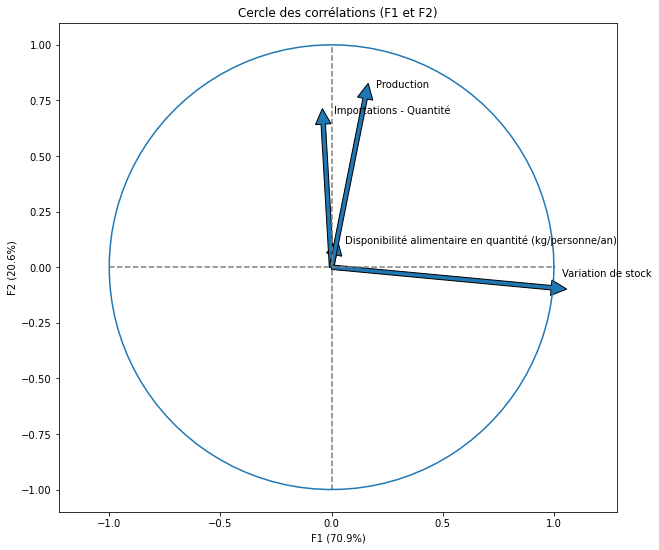

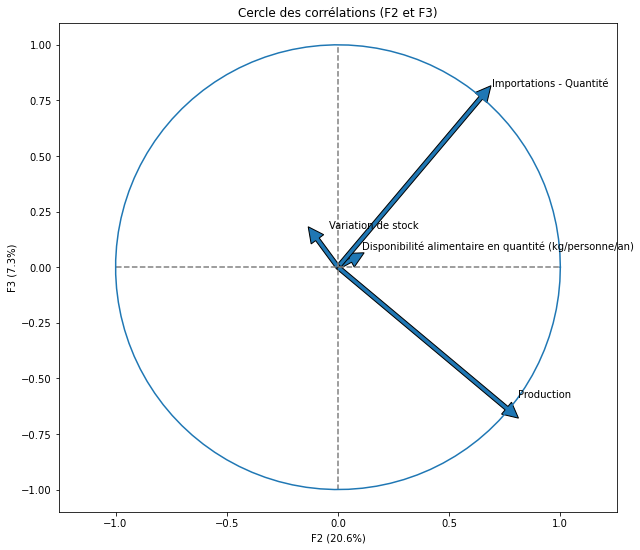

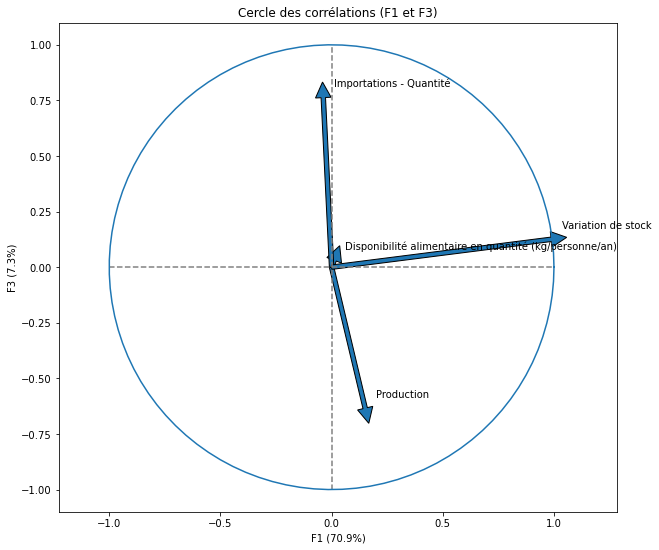

In [26]:
cercle_correlation(ACP, (0,1), colonnes)
cercle_correlation(ACP, (1,2), colonnes)
cercle_correlation(ACP, (0,2), colonnes)

C:\ProgramData\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


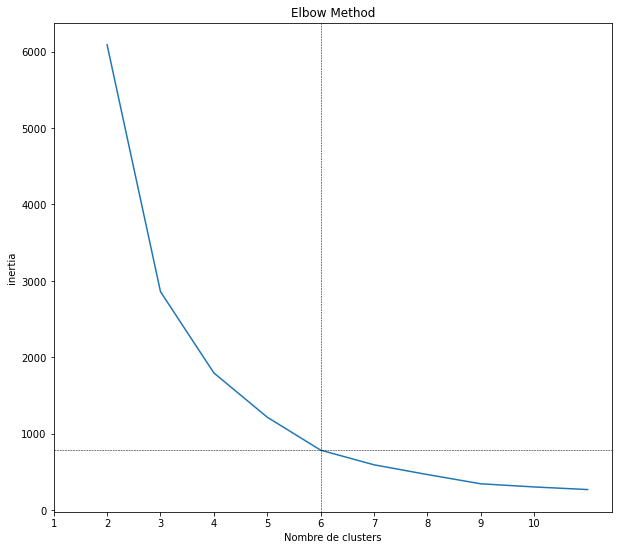

In [27]:
def Elbow(data, k_range=(1, 10)):
    liste_inertielle = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        liste_inertielle.append(kmeans.inertia_)
          
    plt.figure(figsize=(10, 9))        
    plt.plot(range(1, 11), liste_inertielle)
    plt.title('Elbow Method')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('inertia')
    plt.xticks(range(len(liste_inertielle)), range(k_range[0], k_range[1]+1))
    plt.axhline(y=785, color='k', linestyle='--', linewidth=0.5)
    plt.axvline(x=5, color='k', linestyle='--', linewidth=0.5)
    plt.savefig("./images/Methode_coude.svg", format="svg")
    plt.show()
    
# On ne garde que les 2 premiers composante F1 et F2 qui explique le plus de variance de notre jeu de données
res = res[['PC1','PC2']]

Elbow(res)

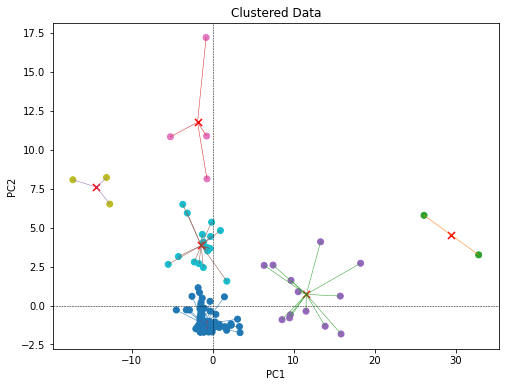

In [28]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)

# On utilise la version simplifié par l'acp afin d'y voir plus claire sur le graphique
acp_cluster = kmeans.fit_predict(res)
acp_cntr = kmeans.cluster_centers_

# Cependant on conserve la version complète afin de pouvoir conserver des chiffres cohérants pour plus tard
cluster = kmeans.fit_predict(Volaille_std)
cntr = kmeans.cluster_centers_

# Créer le graphique
plt.figure(figsize=(8, 6))
plt.scatter(PC[:, 0], PC[:, 1], c=acp_cluster, cmap='tab10')
plt.scatter(acp_cntr[:, 0], acp_cntr[:, 1], c='red', marker='x', s=50)  # Ajouter les centres de clusters en rouge avec un marqueur 'x'

# Tracer les lignes entre les points de données et les centres de clusters
for i in range(len(PC)):
    plt.plot([PC[i, 0], acp_cntr[acp_cluster[i], 0]], [PC[i, 1], acp_cntr[acp_cluster[i], 1]], c=plt.cm.tab10(acp_cluster[i]), linewidth=0.5)

plt.title('Clustered Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
plt.savefig("./images/clusters.svg", format="svg")
plt.show()

In [29]:
profil_cluster = pd.DataFrame(scaler.inverse_transform(cntr), columns=colonnes)
display(profil_cluster)

,Disponibilité alimentaire en quantité (kg/personne/an),Importations - Quantité,Production,Variation de stock
0,18.184733,40.160305,83.351145,2.893130
1,27.429231,75.692308,903.769231,85.769231
2,34.626000,802.800000,1653.600000,-9.400000
3,30.403333,445.333333,1296.666667,-92.000000
4,26.600000,280.500000,2050.500000,204.000000
5,21.053333,99.250000,1529.166667,-3.166667


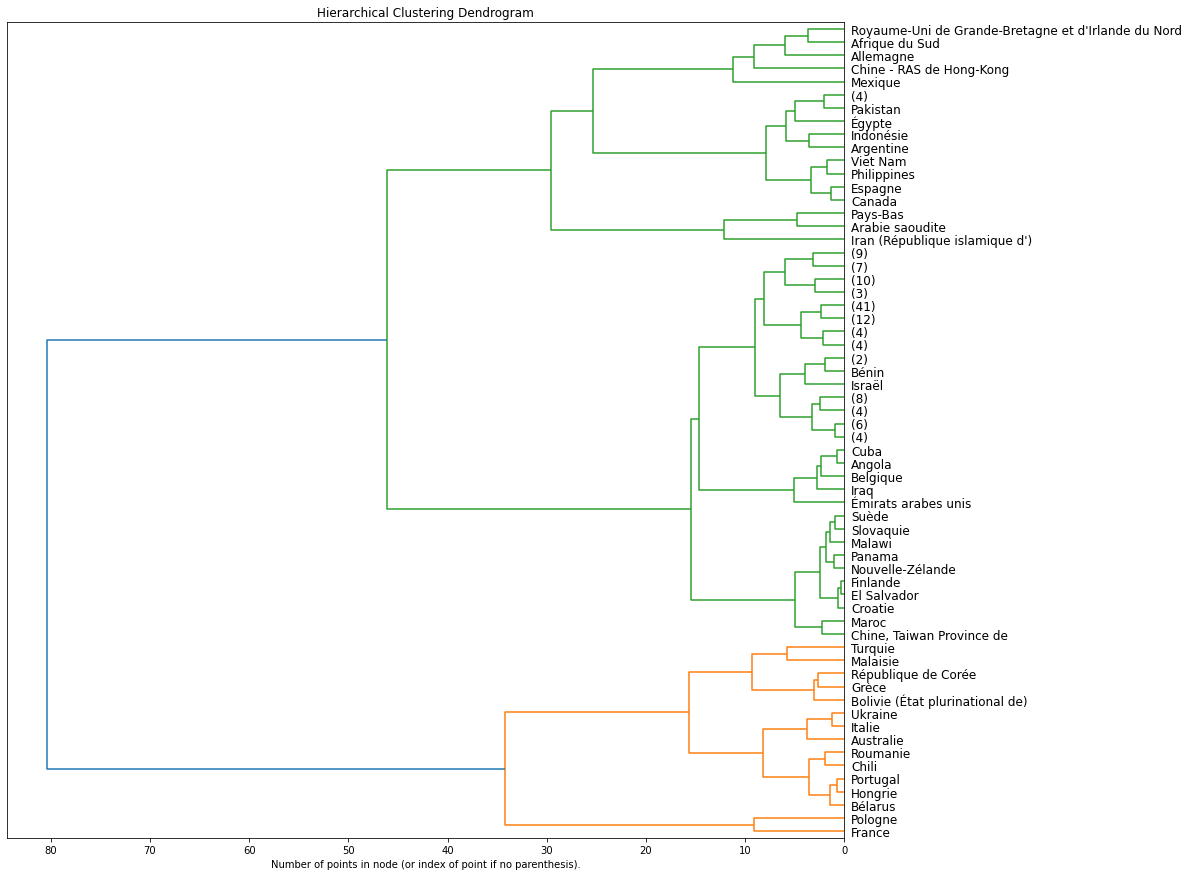

In [30]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        current_count = 0        
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(Volaille_std)

plt.figure(figsize=(15, 15))
plt.title("Hierarchical Clustering Dendrogram")

# Plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=7, labels=Disp_volaille["Zone"].tolist(), leaf_font_size=12, orientation='left')

plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig("./images/dendrogram.svg", format="svg")
plt.show()

In [31]:
Disp_volaille['cluster'] = cluster

for i in Disp_volaille['cluster'].unique():
    display(Disp_volaille[Disp_volaille['cluster']==i])

,Zone,Disponibilité alimentaire en quantité (kg/personne/an),Importations - Quantité,Production,Variation de stock,cluster
0,Afghanistan,1.53,29.0,28.0,0.0,0
2,Albanie,16.36,38.0,13.0,4.0,0
3,Algérie,6.38,2.0,275.0,0.0,0
5,Angola,10.56,277.0,42.0,-0.0,0
6,Antigua-et-Barbuda,54.10,7.0,0.0,0.0,0
...,...,...,...,...,...,...
165,Zimbabwe,4.68,6.0,69.0,-0.0,0
167,Émirats arabes unis,43.47,433.0,48.0,-26.0,0
168,Équateur,19.31,0.0,340.0,-1.0,0
170,Éthiopie,0.13,1.0,14.0,0.0,0


,Zone,Disponibilité alimentaire en quantité (kg/personne/an),Importations - Quantité,Production,Variation de stock,cluster
1,Afrique du Sud,35.69,514.0,1667.0,-0.0,2
4,Allemagne,19.47,842.0,1514.0,-29.0,2
31,Chine - RAS de Hong-Kong,53.51,907.0,24.0,-12.0,2
98,Mexique,32.52,972.0,3249.0,-6.0,2
124,Royaume-Uni de Grande-Bretagne et d'Irlande du...,31.94,779.0,1814.0,0.0,2


,Zone,Disponibilité alimentaire en quantité (kg/personne/an),Importations - Quantité,Production,Variation de stock,cluster
7,Arabie saoudite,43.36,722.0,616.0,-108.0,3
68,Iran (République islamique d'),27.52,6.0,2174.0,-86.0,3
117,Pays-Bas,20.33,608.0,1100.0,-82.0,3


,Zone,Disponibilité alimentaire en quantité (kg/personne/an),Importations - Quantité,Production,Variation de stock,cluster
8,Argentine,42.24,8.0,2161.0,0.0,5
29,Canada,39.02,182.0,1417.0,3.0,5
36,Colombie,31.99,78.0,1564.0,-4.0,5
46,Espagne,30.39,205.0,1515.0,11.0,5
67,Indonésie,7.19,1.0,2301.0,-21.0,5
102,Myanmar,30.37,3.0,1662.0,-1.0,5
114,Pakistan,5.86,2.0,1281.0,-3.0,5
118,Philippines,13.87,249.0,1272.0,-3.0,5
122,Pérou,13.47,60.0,1465.0,0.0,5
151,Thaïlande,12.95,2.0,1676.0,1.0,5


,Zone,Disponibilité alimentaire en quantité (kg/personne/an),Importations - Quantité,Production,Variation de stock,cluster
10,Australie,47.65,16.0,1269.0,71.0,1
18,Bolivie (État plurinational de),36.00,1.0,533.0,103.0,1
24,Bélarus,27.98,21.0,463.0,67.0,1
30,Chili,36.36,155.0,712.0,80.0,1
57,Grèce,15.32,79.0,246.0,118.0,1
65,Hongrie,25.27,58.0,493.0,74.0,1
73,Italie,18.88,97.0,1315.0,56.0,1
90,Malaisie,39.21,68.0,1724.0,128.0,1
121,Portugal,30.58,82.0,361.0,74.0,1
123,Roumanie,19.37,146.0,392.0,88.0,1


,Zone,Disponibilité alimentaire en quantité (kg/personne/an),Importations - Quantité,Production,Variation de stock,cluster
51,France,22.9,506.0,1750.0,183.0,4
119,Pologne,30.3,55.0,2351.0,225.0,4


<Figure size 360x360 with 0 Axes>

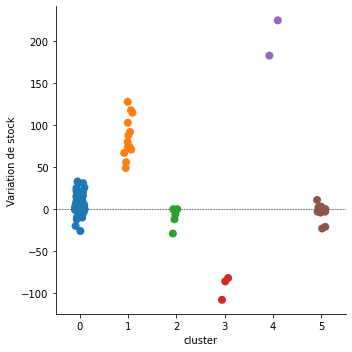

In [32]:
plt.figure(figsize=(5, 5))
sns.catplot(data=Disp_volaille, x="cluster", y="Variation de stock", s=8)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.savefig("./images/clust_variation_stock.svg", format="svg")
plt.show()

<Figure size 360x360 with 0 Axes>

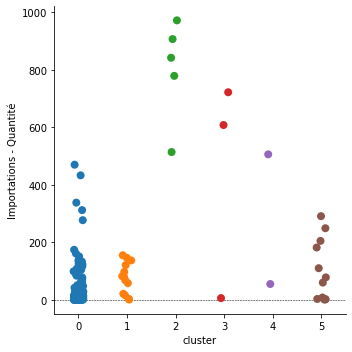

In [33]:
plt.figure(figsize=(5, 5))
sns.catplot(data=Disp_volaille, x="cluster", y="Importations - Quantité", s=8)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.savefig("./images/clust_Import.svg", format="svg")
plt.show()

<Figure size 360x360 with 0 Axes>

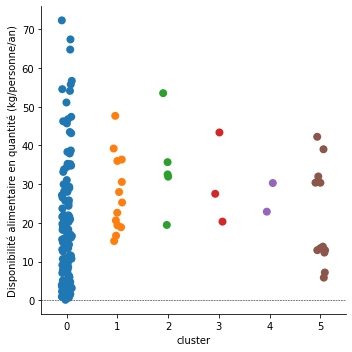

In [34]:
plt.figure(figsize=(5, 5))
sns.catplot(data=Disp_volaille, x="cluster", y="Disponibilité alimentaire en quantité (kg/personne/an)", s=8)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.savefig("./images/clust_disp_kg-pers-an.svg", format="svg")
plt.show()

<Figure size 360x360 with 0 Axes>

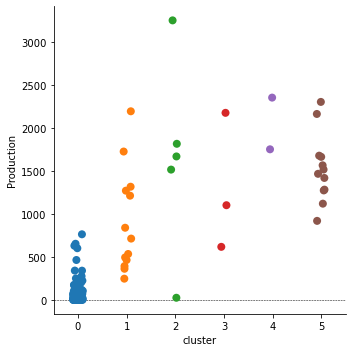

In [35]:
plt.figure(figsize=(5, 5))
sns.catplot(data=Disp_volaille, x="cluster", y="Production", s=8)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.savefig("./images/clust_production.svg", format="svg")
plt.show()

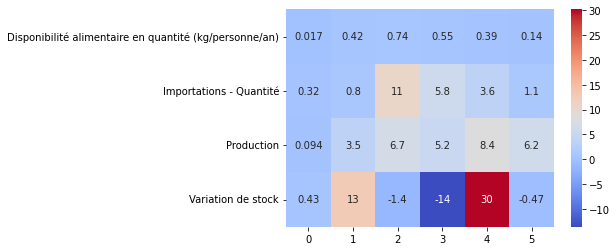

In [36]:
# On récupère 'cntr' qui contient nos centroïdes de cluster normalisé afin que la heatmap soit cohérante.

profil_cluster_std = pd.DataFrame(data=cntr)
profil_cluster_std = profil_cluster_std.rename(columns={0: colonnes[0], 1: colonnes[1], 2: colonnes[2], 3: colonnes[3]})
profil_cluster_std = profil_cluster_std.T

sns.heatmap(data=profil_cluster_std, annot=True, cmap='coolwarm')
plt.savefig("./images/heatmap.svg", format="svg")
plt.show()

In [37]:
Choix_final = pd.concat([ Disp_volaille.loc[[1,4,31,98,124,7,117,67,118,166]], Outliers[Outliers.index.isin([34, 66])] ])

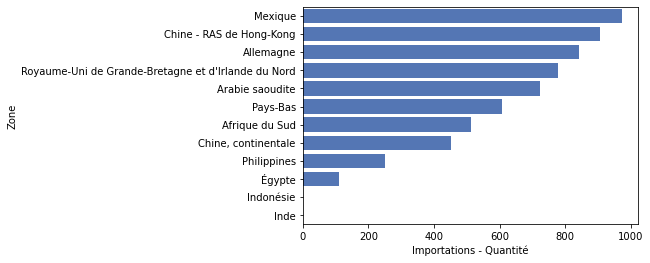

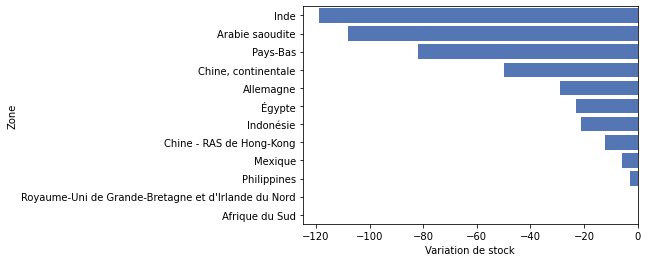

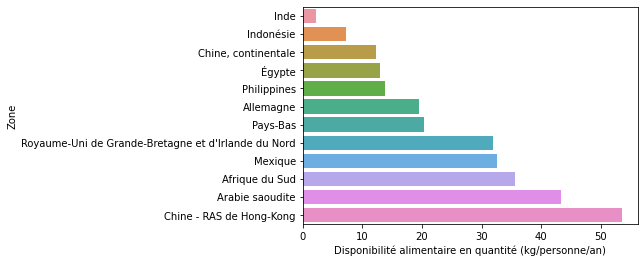

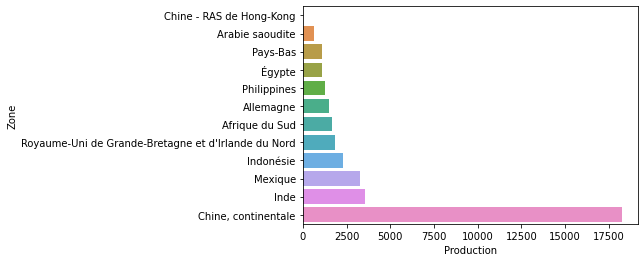

In [38]:
Choix_final = Choix_final.sort_values(by='Importations - Quantité', ascending=False)
sns.barplot(x='Importations - Quantité', y='Zone', data=Choix_final, orient='h', color='#4472C4')
plt.savefig("./images/Import.svg", format="svg")
plt.show()

Choix_final = Choix_final.sort_values(by='Variation de stock', ascending=True)
sns.barplot(x='Variation de stock', y='Zone', data=Choix_final, orient='h', color='#4472C4')
plt.savefig("./images/Variation_de_stock.svg", format="svg")
plt.show()

Choix_final = Choix_final.sort_values(by='Disponibilité alimentaire en quantité (kg/personne/an)', ascending=True)
sns.barplot(x='Disponibilité alimentaire en quantité (kg/personne/an)', y='Zone', data=Choix_final, orient='h')
plt.show()

Choix_final = Choix_final.sort_values(by='Production', ascending=True)
sns.barplot(x='Production', y='Zone', data=Choix_final, orient='h')
plt.show()